
# Maximum Cut Problem


## Introduction

The "Maximum Cut Problem" (MaxCut) [[1](#MaxCutWiki)] is an example of combinatorial optimization problem. It refers to finding a partition of a graph into two sets, such that the number of edges between the two sets is maximal. This optimization problem is the cardinal example in the context of Quantum Approximate Optimization Algorithm [[2](#QAOA)], since it is an unconstrained problem whose objective function in terms quantum gates can be derived easily. With the Classiq platform, things are even simpler, as the objective function is inserted in its arithmetic form.

## Mathematical formulation

Given a graph $G=(V,E)$ with $|V|=n$ nodes and $E$ edges, a cut is defined as a partition of the graph into two complementary subsets of nodes. In the MaxCut problem we are looking for a cut where the number of edges between the two subsets is maximal. We can represent a cut of the graph by a binary vector $x$ of size $n$, where we assign 0 and 1 to nodes in the first and second subsets, respectively. The number of connecting edges for a given cut is simply given by summing over $x_i (1-x_j)+x_j (1-x_i)$ for every pair of connected nodes $(i,j)$.

# Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[2](#QAOA)]. The solution is based on defining a pyomo model for the optimization problem we would like to solve.

In [1]:
import networkx as nx
import numpy as np
import pyomo.core as pyo
from IPython.display import Markdown, display
from matplotlib import pyplot as plt

## Building the Pyomo model from a graph input

We proceed by defining the pyomo model that will be used on the Classiq platform, using the mathematical formulation defined above:

In [2]:
# we define a function which returns 1 if two connected nodes are on a different subset, and 0 otherwise


def arithmetic_eq(x1: int, x2: int) -> int:
    return x1 * (1 - x2) + x2 * (1 - x1)


# we define a function which returns the pyomo model for a graph input
def maxcut(graph: nx.Graph) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel()
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)

    model.cost = pyo.Objective(
        expr=sum(
            arithmetic_eq(model.x[node1], model.x[node2])
            for (node1, node2) in graph.edges
        ),
        sense=pyo.maximize,
    )

    return model

## Generating a specific problem

Let us pick a specific problem:


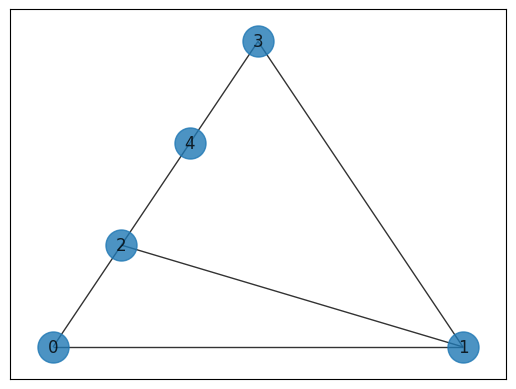

In [3]:
# Create graph
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)])
pos = nx.planar_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=True, alpha=0.8, node_size=500)
maxcut_model = maxcut(G)

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):

In [4]:
from classiq import *
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=4)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [5]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=0.7)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [6]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=maxcut_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [7]:
from classiq.execution import ClassiqBackendPreferences

qmod = set_execution_preferences(
    qmod, backend_preferences=ClassiqBackendPreferences(backend_name="simulator")
)

In [8]:
write_qmod(qmod, "max_cut")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [9]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/7217a54b-03a1-446e-9c66-b87ca4266918?version=0.41.0.dev39%2B79c8fd0855


We now solve the problem by calling the `execute` function on the quantum program we have generated:

In [10]:
result = execute(qprog).result_value()

We can check the convergence of the run:

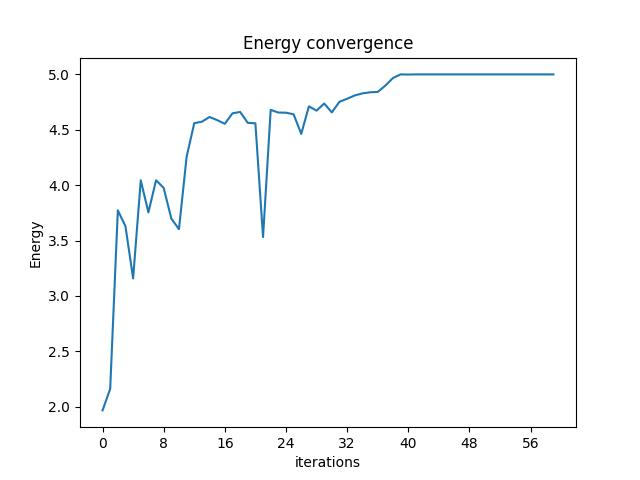

In [11]:
result.convergence_graph

# Optimization Results

We can also examine the statistics of the algorithm:

In [12]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    maxcut_model, vqe_result=result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=False).head(5)

,probability,cost,solution,count
0,0.201,5.0,"[0, 0, 1, 1, 0]",201
2,0.187,5.0,"[1, 1, 0, 0, 1]",187
3,0.171,5.0,"[0, 1, 0, 0, 1]",171
1,0.199,5.0,"[1, 0, 1, 1, 0]",199
4,0.040,4.0,"[1, 0, 0, 1, 1]",40


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

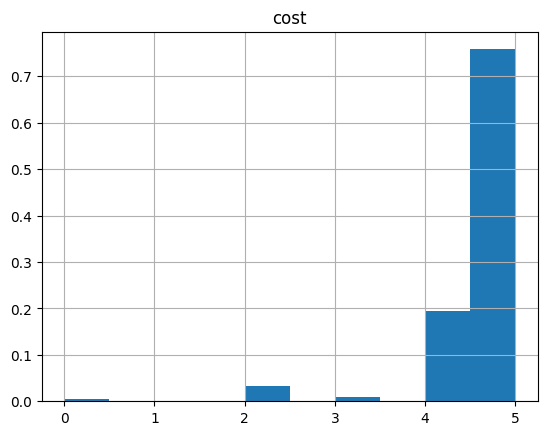

In [13]:
optimization_result.hist("cost", weights=optimization_result["probability"])

Let us plot the solution:

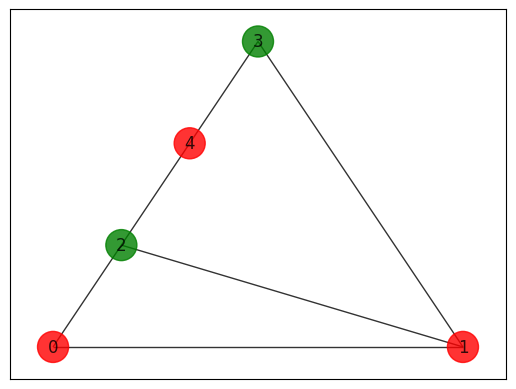

In [14]:
best_solution = optimization_result.solution[optimization_result.cost.idxmax()]

colors = ["r" if best_solution[i] == 0 else "g" for i in range(5)]
nx.draw_networkx(
    G, pos=pos, with_labels=True, alpha=0.8, node_size=500, node_color=colors
)

## Classical optimizer results

Lastly, we can compare to the classical solution of the problem:

In [15]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(maxcut_model)

maxcut_model.display()

Model unknown

  Variables:
    x : Size=5, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :     1 : False : False : Binary
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   1.0 :     1 : False : False : Binary
          3 :     0 :   1.0 :     1 : False : False : Binary
          4 :     0 :   0.0 :     1 : False : False : Binary

  Objectives:
    cost : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   5.0

  Constraints:
    None


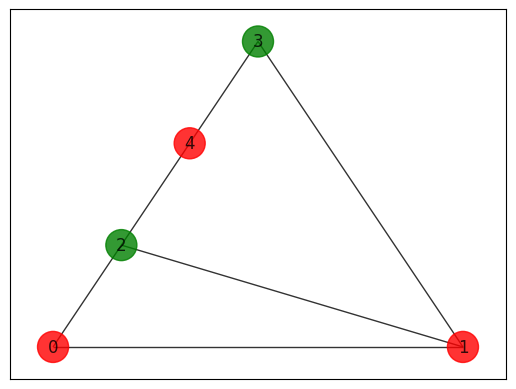

In [16]:
solution = [pyo.value(maxcut_model.x[i]) for i in G.nodes]
colors = ["r" if best_solution[i] == 0 else "g" for i in range(5)]
nx.draw_networkx(
    G, pos=pos, with_labels=True, alpha=0.8, node_size=500, node_color=colors
)


## References

<a id='MaxCutWiki'>[1]</a>: [Maximum Cut Problem (Wikipedia)](https://en.wikipedia.org/wiki/Maximum_cut)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
